In [1]:
import warnings;
warnings.simplefilter('ignore')

In [2]:
#!pip install prophet

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import numpy as np
from neuralprophet import NeuralProphet


In [4]:
data = pd.read_csv('crime-per-county.csv')

In [5]:
data.head()


,STATISTIC Label,Quarter,Garda Division,Type of Offence,UNIT,VALUE
0,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Homicide offences,Number,1.0
1,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Murder,Number,0.0
2,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Manslaughter,Number,0.0
3,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Infanticide,Number,0.0
4,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Dangerous driving leading to death,Number,1.0


In [6]:
data.drop(columns =["STATISTIC Label", "UNIT"], inplace=True)

In [7]:
data['VALUE'] = data['VALUE'].fillna(0)
data['VALUE'] = data['VALUE'].astype('int64')

In [8]:
def quarter_to_date(year_quarter):
    year, quarter = year_quarter.split('Q')
    first_month = {'1': '01', '2' : '04' , '3' : '07' , '4' : '10'}
    return f"{year}-{first_month[quarter]}-1"

data['Date'] = data['Quarter'].apply(quarter_to_date)


In [9]:
# Correct way using .loc to avoid SettingWithCopyWarning
data.loc[:, 'Date'] = pd.to_datetime(data['Date'])



In [10]:
data['Date'] = pd.to_datetime(data['Date'])

In [11]:
#data.set_index('Date', inplace=True)

In [12]:
data.drop(columns =['Quarter'], inplace=True)

In [13]:
data = data[data['VALUE'] != 0]

In [14]:
data.info() 
data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 120808 entries, 0 to 166991
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Garda Division   120808 non-null  object        
 1   Type of Offence  120808 non-null  object        
 2   VALUE            120808 non-null  int64         
 3   Date             120808 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 4.6+ MB


,VALUE,Date
count,120808.000000,120808
mean,81.256763,2013-06-16 19:43:56.408185088
min,1.000000,2003-01-01 00:00:00
25%,2.000000,2008-04-01 00:00:00
50%,16.000000,2013-07-01 00:00:00
75%,86.000000,2018-10-01 00:00:00
max,2541.000000,2023-10-01 00:00:00
std,170.400775,NaN


In [15]:
# Filter the data for "Theft from person" crimes in "D.M.R. North Central Garda Division"
theft_from_person_data = data[
    (data['Type of Offence'] == 'Robbery from the person') & 
    (data['Garda Division'] == 'D.M.R. North Central Garda Division')
]

In [16]:
theft_from_person_data.drop(columns =['Garda Division', 'Type of Offence'], inplace=True)

In [17]:
theft_from_person_data.head()

,VALUE,Date
1663,74,2003-01-01
3651,55,2003-04-01
5639,76,2003-07-01
7627,45,2003-10-01
9615,61,2004-01-01


In [18]:
theft_from_person_data.columns =['y', 'ds']

In [19]:
theft_from_person_data.head()

,y,ds
1663,74,2003-01-01
3651,55,2003-04-01
5639,76,2003-07-01
7627,45,2003-10-01
9615,61,2004-01-01


In [20]:
# Extracting only the year from the 'ds' column
#data['ds'] = data['ds'].dt.year

In [21]:
m = NeuralProphet()
m.fit(theft_from_person_data, freq = 'Q', epochs = 1000)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 79.762% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - QS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (11) is too small than the required number                     for the learning rate finder (206). The results might not be optimal.


Finding best initial lr:   0%|          | 0/206 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,78.248772,82.654633,0.764459,0.0,0
1,71.992950,76.764313,0.694087,0.0,1
2,65.301064,70.005928,0.618153,0.0,2
3,59.121334,63.600632,0.551075,0.0,3
4,53.518932,58.688232,0.488362,0.0,4
...,...,...,...,...,...
995,6.288447,8.119532,0.016343,0.0,995
996,6.158494,7.846254,0.015991,0.0,996
997,6.213921,8.151936,0.016204,0.0,997
998,6.379576,8.253133,0.016918,0.0,998


In [22]:
future = m.make_future_dataframe(theft_from_person_data, periods=10)
forecast = m.predict(future)
forecast.head(20)

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 79.762% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - QS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 70.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - QS
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 70.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - QS


Predicting: 11it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly
0,2024-01-01,None,33.720352,70.576324,-36.855968
1,2024-04-01,None,23.960318,69.731415,-45.771099
2,2024-07-01,None,24.083225,68.886505,-44.803280
3,2024-10-01,None,19.086040,68.032303,-48.946262
4,2025-01-01,None,23.864420,67.178116,-43.313690
5,2025-04-01,None,23.413872,66.342499,-42.928623
6,2025-07-01,None,23.393831,65.497581,-42.103752
7,2025-10-01,None,19.517349,64.643387,-45.126041
8,2026-01-01,None,22.599329,63.789200,-41.189869
9,2026-04-01,None,22.848492,62.953575,-40.105083


# Prophet

In [23]:
from prophet import Prophet

In [24]:
theft_from_person_data.describe()

,y,ds
count,84.000000,84
mean,53.523810,2013-05-16 19:08:34.285714176
min,24.000000,2003-01-01 00:00:00
25%,40.750000,2008-03-09 06:00:00
50%,48.000000,2013-05-16 12:00:00
75%,61.750000,2018-07-24 00:00:00
max,113.000000,2023-10-01 00:00:00
std,18.522846,NaN


In [25]:
m_prophet = Prophet(
    changepoint_prior_scale=0.5,   # Default is 0.05, increase for more flexibility
    seasonality_prior_scale=10.0,  # Default is 10, adjust as needed
    holidays_prior_scale=0.1,      # Default is 10, decrease for less flexible holidays
    seasonality_mode='multiplicative'  # Especially useful if seasonality magnitude grows over time
)
model_prophet = m_prophet.fit(theft_from_person_data)

14:01:56 - cmdstanpy - INFO - Chain [1] start processing
14:01:57 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
future_prophet = m_prophet.make_future_dataframe(periods=8, freq = 'QS')


In [27]:
forecast_prophet = m_prophet.predict(future_prophet)
forecast_prophet.tail(5)



,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
87,2024-10-01,0.887274,4.220398,48.806480,0.155834,1.536229,29.374961,29.374961,29.374961,29.374961,29.374961,29.374961,0.0,0.0,0.0,26.950915
88,2025-01-01,0.865630,-6.159929,65.646498,-0.163035,1.811683,33.756200,33.756200,33.756200,33.756200,33.756200,33.756200,0.0,0.0,0.0,30.086014
89,2025-04-01,0.844457,-15.456187,68.476843,-0.500825,2.150669,30.542623,30.542623,30.542623,30.542623,30.542623,30.542623,0.0,0.0,0.0,26.636380
90,2025-07-01,0.823048,-29.485525,82.703118,-0.868826,2.501281,31.286210,31.286210,31.286210,31.286210,31.286210,31.286210,0.0,0.0,0.0,26.573102
91,2025-10-01,0.801404,-39.176912,91.503010,-1.240740,2.845809,30.270901,30.270901,30.270901,30.270901,30.270901,30.270901,0.0,0.0,0.0,25.060629


In [28]:
forecast_prophet[['ds', 'yhat']].tail(7)


,ds,yhat
85,2024-04-01,29.390235
86,2024-07-01,28.831110
87,2024-10-01,26.950915
88,2025-01-01,30.086014
89,2025-04-01,26.636380
90,2025-07-01,26.573102
91,2025-10-01,25.060629


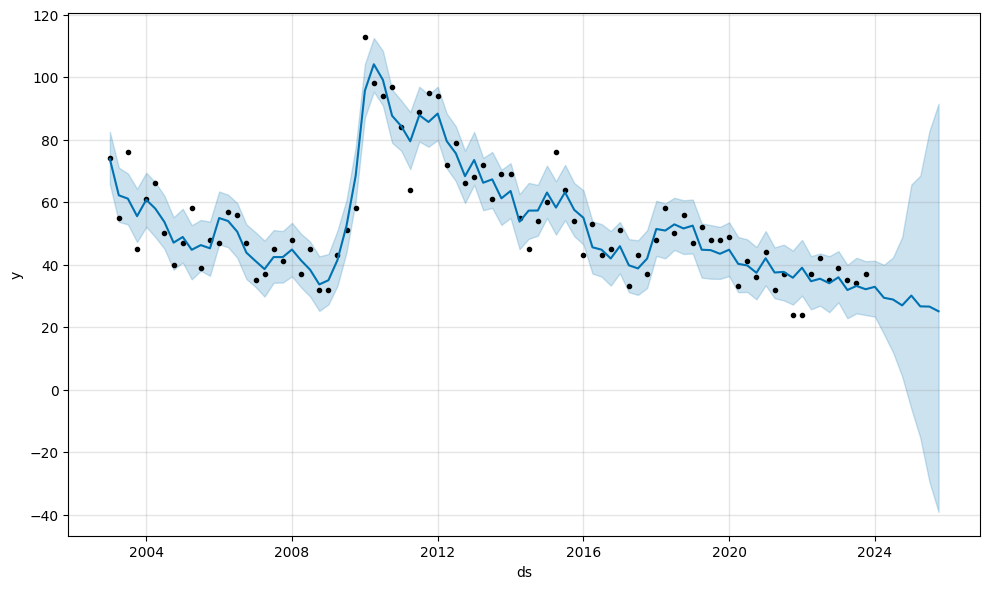

In [29]:
plot1 = m_prophet.plot(forecast_prophet)

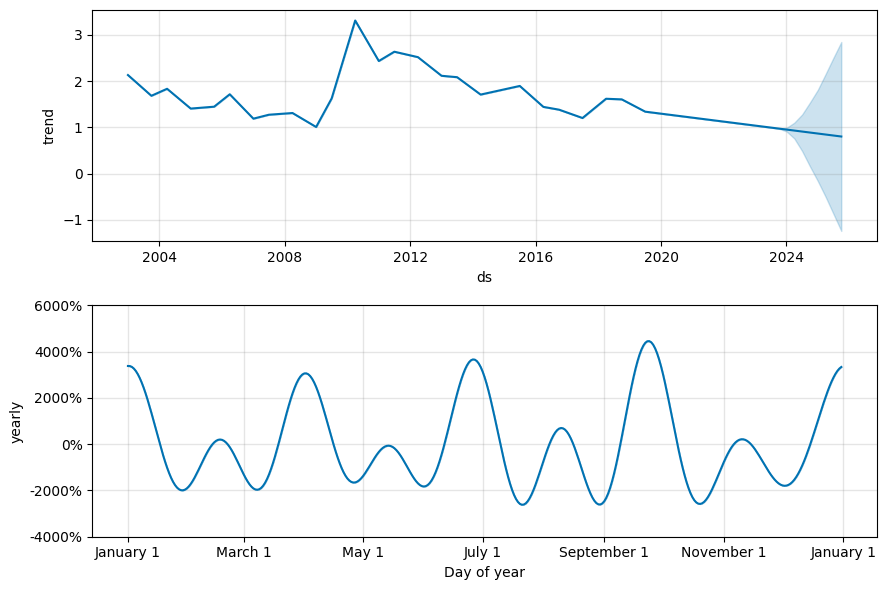

In [30]:
plot2 = m_prophet.plot_components(forecast_prophet)

In [31]:
from sklearn.metrics import r2_score

In [32]:
# Assuming 'theft_from_person_data' is your actual data and 'forecast' is your prediction
# Filter 'forecast' to match the date range in 'theft_from_person_data'
forecast_filtered = forecast_prophet[forecast_prophet['ds'].isin(theft_from_person_data['ds'])]

# Now, reassign y_pred to make sure it only includes matched predictions
y_pred = forecast_filtered['yhat'].values
y_true = theft_from_person_data['y'].values

# Calculate R² score
r2 = r2_score(y_true, y_pred)
print(f"R² Score: {r2}")



R² Score: 0.8670739756440806


In [33]:
from prophet.diagnostics import cross_validation, performance_metrics